In [2]:
from constants import *

In [32]:
n_channels = 22

data_path = '/Users/seonghyunyoon/Developer/cp-eeg/Data/2aiv/'
save_path = '/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 2 (loso)/'
model_path = f'{save_path}/saved_models/'

In [33]:
all_X_train = [] 
all_y_train = [] 
all_X_val = []
all_y_val = []
all_X_test = []
all_y_test = []

all_models = [] 

for subject_num in tqdm(range(1, 10)): 
    # Load data 
    
    X_test = []
    y_test = []
    X_train_val = []
    y_train_val = []

    for i in range(1, 10): 
        if i == subject_num: 
            X, y = get_data(i, training=True, path=data_path)
            X_test.append(X); y_test.append(y)
            X, y = get_data(i, training=False, path=data_path)
            X_test.append(X); y_test.append(y)
        else: 
            X, y = get_data(i, training=True, path=data_path)
            X_train_val.append(X); y_train_val.append(y)
            X, y = get_data(i, training=False, path=data_path)
            X_train_val.append(X); y_train_val.append(y)
    X_train_val = np.vstack(X_train_val); y_train_val = np.hstack(y_train_val)
    X_test = np.vstack(X_test); y_test = np.hstack(y_test)
    X_train_val, y_train_val = prepare_features(X_train_val, y_train_val); X_test, y_test = prepare_features(X_test, y_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=.9, random_state=42)
    
    # Scale the data
    for j in range(n_channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
    # Append to total data 
    all_X_train.append(X_train); all_y_train.append(y_train)
    all_X_val.append(X_val); all_y_val.append(y_val)
    all_X_test.append(X_test); all_y_test.append(y_test)
    
    # Prepare model
    curr_model_path = f'{model_path}/loso_{subject_num}.h5'
    _, _, n_channels, n_time = X_train.shape
    n_classes = y_train.shape[1]
    model = EEGTCNet(nb_classes = n_classes, Chans=n_channels, Samples=n_time, layers=L, kernel_s=KT, filt=FT, dropout=pt, activation='elu', 
                     F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    model.load_weights(curr_model_path)

    all_models.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

In [34]:
0.63 * np.sum([all_X_test[i].shape[0] for i in range(9)]) / (9)

328.72

## Calibration plot

In [136]:
# Prepare all values of alphas 
all_alphas = np.arange(0.01, 0.99, 0.01)
n_alphas = len(all_alphas)
n_iters = 100
n_classes = 4

empirical_coverages = np.zeros((9 * n_iters, n_alphas))
accuracies = np.zeros((9 * n_iters, n_alphas))
prediction_rates = np.zeros((9 * n_iters, n_alphas))

baseline_accuracy = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    # Load Relevant model and data
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    _, X_test, _, y_test = train_test_split(X_test, y_test, test_size=0.5)
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for i_alpha, alpha in enumerate(all_alphas): 
        for i_iter in range(n_iters): 
            save_idx = subject_num*n_iters + i_iter
            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=False)
            empirical_coverages[save_idx, i_alpha] = get_coverage(y_test, pred_set)

            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True)
            set_size = get_set_size(pred_set, n_classes)
            prediction_rates[save_idx, i_alpha] = (set_size[0] + set_size[1]) / sum(set_size.values())
            accuracies[save_idx, i_alpha] = get_abstain_metrics(pred_set, test_smx, y_test, verbose=False)
        
    baseline_accuracy[subject_num] = np.mean(test_smx.argmax(1) == y_test.argmax(1))
    
np.save(f'{save_path}baseline_accuracies.npy', baseline_accuracy)
np.save(f'{save_path}empirical_coverages.npy', empirical_coverages)
np.save(f'{save_path}accuracies.npy', accuracies)
np.save(f'{save_path}prediction_rates.npy', prediction_rates)

  0%|          | 0/9 [00:00<?, ?it/s]

In [137]:
baseline_accuracy = np.load(f'{save_path}baseline_accuracies.npy')
empirical_coverages = np.load(f'{save_path}empirical_coverages.npy')
accuracies = np.load(f'{save_path}accuracies.npy')
prediction_rates = np.load(f'{save_path}prediction_rates.npy')

In [138]:
# Prepare all values of alphas 
all_alphas = np.arange(0.01, 0.99, 0.01)
n_alphas = len(all_alphas)
n_iters = 100
n_classes = 4

empirical_coverages_same = np.zeros((9 * n_iters, n_alphas))
accuracies_same = np.zeros((9 * n_iters, n_alphas))
prediction_rates_same = np.zeros((9 * n_iters, n_alphas))

for subject_num in tqdm(range(9)): 
    # Load Relevant model and data
    model = all_models[subject_num]
    X_val_test = all_X_test[subject_num]; y_val_test = all_y_test[subject_num]
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for i_alpha, alpha in enumerate(all_alphas): 
        for i_iter in range(n_iters): 
            save_idx = subject_num*n_iters + i_iter
            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=False)
            empirical_coverages_same[save_idx, i_alpha] = get_coverage(y_test, pred_set)

            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True)
            set_size = get_set_size(pred_set, n_classes)
            prediction_rates_same[save_idx, i_alpha] = (set_size[0] + set_size[1]) / sum(set_size.values())
            accuracies_same[save_idx, i_alpha] = get_abstain_metrics(pred_set, test_smx, y_test, verbose=False)
        
np.save(f'{save_path}empirical_coverages_same.npy', empirical_coverages_same)
np.save(f'{save_path}accuracies_same.npy', accuracies_same)
np.save(f'{save_path}prediction_rates_same.npy', prediction_rates_same)

  0%|          | 0/9 [00:00<?, ?it/s]

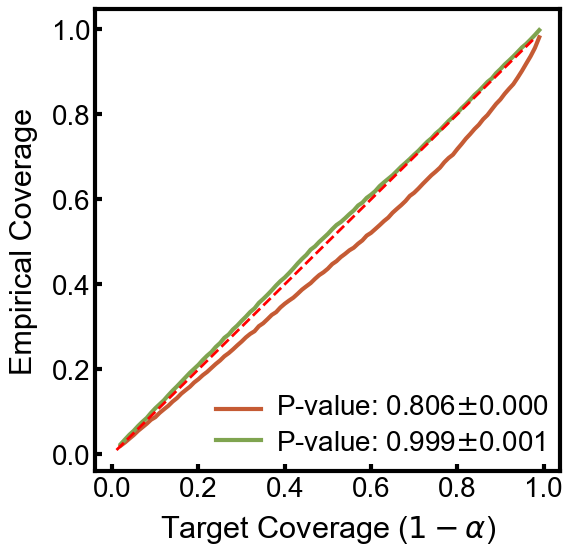

In [139]:
all_alphas = np.arange(0.01, 0.99, 0.01)
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
avg, ci_lower, ci_upper = compute_ci_mean(empirical_coverages)
plt.plot(1-all_alphas, avg, color=color_scheme[0], linewidth=3)
plt.fill_between(1-all_alphas, ci_lower, ci_upper, color=color_scheme[0], alpha=.2, linewidth=0)
pvalue = stats.kstest(1-all_alphas, avg, alternative='two-sided')[1]
low_pvalue = stats.kstest(1-all_alphas, ci_lower, alternative='two-sided')[1]
if pvalue > 0.999: 
    pvalue = 0.999
plt.text(0.38, 0.095, fr'P-value: {pvalue:.3f}$\pm${np.abs(low_pvalue-pvalue):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.plot([0.24, 0.345], [0.106, 0.106], color=color_scheme[0], linewidth=3)

avg_same, ci_lower_same, ci_upper_same = compute_ci_mean(empirical_coverages_same)
plt.plot(1-all_alphas, avg_same, color=color_scheme[2], linewidth=3)
plt.fill_between(1-all_alphas, ci_lower_same, ci_upper_same, color=color_scheme[2], alpha=.2, linewidth=0)
pvalue = stats.kstest(1-all_alphas, avg_same, alternative='two-sided')[1]
low_pvalue = stats.kstest(1-all_alphas, ci_lower_same, alternative='two-sided')[1]
if pvalue > 0.999: 
    pvalue = 0.999
plt.text(0.38, 0.01, fr'P-value: {pvalue:.3f}$\pm${np.abs(low_pvalue-pvalue):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.plot([0.24, 0.345], [0.0325, 0.0325], color=color_scheme[2], linewidth=3)

plt.plot(all_alphas, all_alphas, 'r--', label='y=x', linewidth=2)  # 'k--' is for black dotted line
plt.grid(False)

plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Empirical Coverage', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))

plt.show()

## Comparison with calibration set from target distribution

In [44]:
empirical_coverages_same = np.load(f'{save_path}empirical_coverages_same.npy')
accuracies_same = np.load(f'{save_path}accuracies_same.npy')
prediction_rates_same = np.load(f'{save_path}prediction_rates_same.npy')
baseline_accuracy = np.load(f'{save_path}baseline_accuracies.npy')

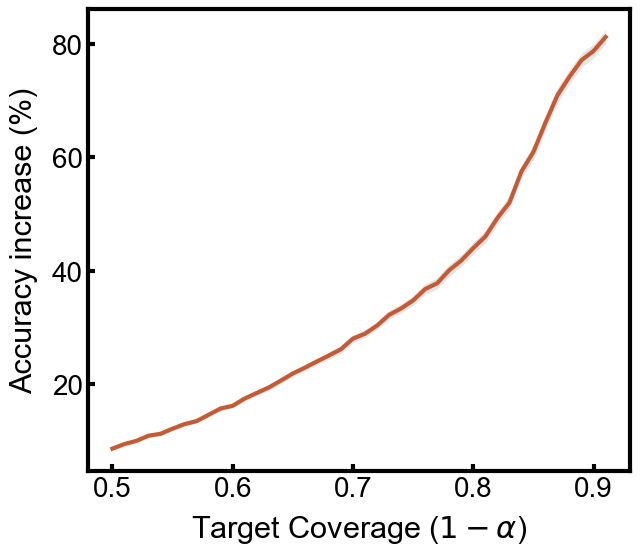

In [45]:
acc_improvement_same, acc_avg_same, acc_ci_lower_same, acc_ci_upper_same = plot_average(np.expand_dims(accuracies_same, axis=0), plot_type='accuracies', 
                                                                                        baseline_accuracy=baseline_accuracy, n_iters=100)

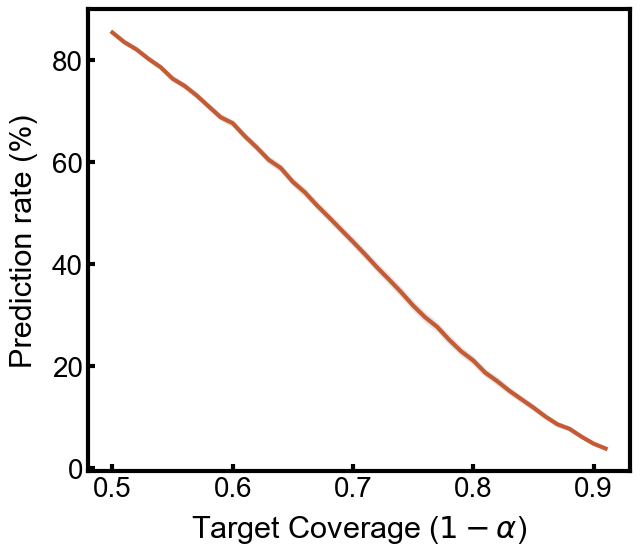

In [46]:
pr_avg_same, pr_ci_lower_same, pr_ci_upper_same = plot_average(np.expand_dims(prediction_rates_same, axis=0), plot_type='prediction_rates')

In [47]:
alpha_max_same_idx = normalized_f1_score(acc_improvement_same.T, pr_avg_same)
acc_avg_max_same = acc_avg_same.T[alpha_max_same_idx][0]
pr_avg_max_same = pr_avg_same.T[alpha_max_same_idx][0]

In [52]:
acc_avg_max_same

32.25076587098733

In [51]:
pr_avg_same.T[alpha_max_same_idx]

array([36.88121173])

### Without data from target distribution

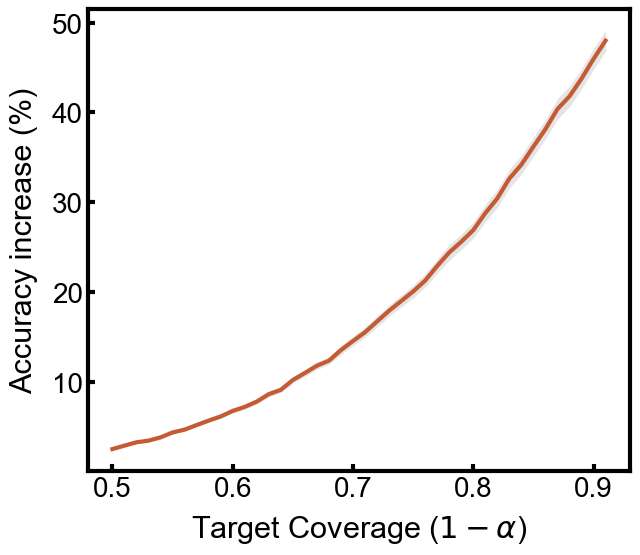

In [143]:
acc_improvement, acc_avg, acc_ci_lower, acc_ci_upper = plot_average(np.expand_dims(accuracies, axis=0), plot_type='accuracies', baseline_accuracy=baseline_accuracy, n_iters=100)

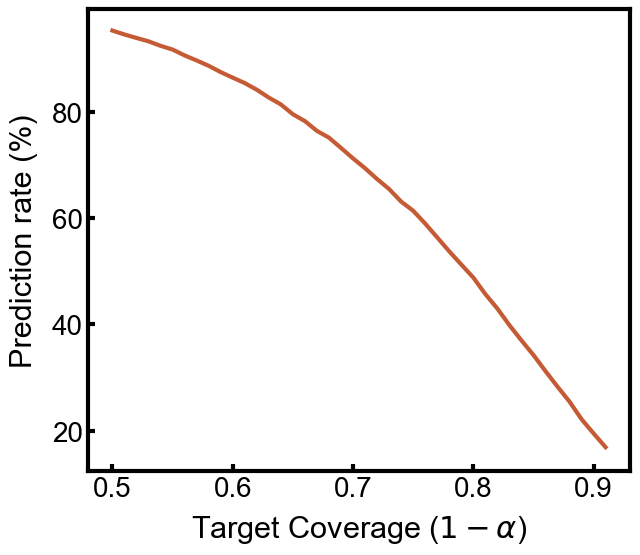

In [144]:
pr_avg, pr_ci_lower, pr_ci_upper = plot_average(np.expand_dims(prediction_rates, axis=0), plot_type='prediction_rates')

In [145]:
acc_avg.shape

(1, 42)

In [146]:
alpha_max_idx = normalized_f1_score(acc_improvement.T, pr_avg)
acc_avg_max = acc_avg.T[alpha_max_idx][0]
pr_avg_max = pr_avg.T[alpha_max_idx][0]

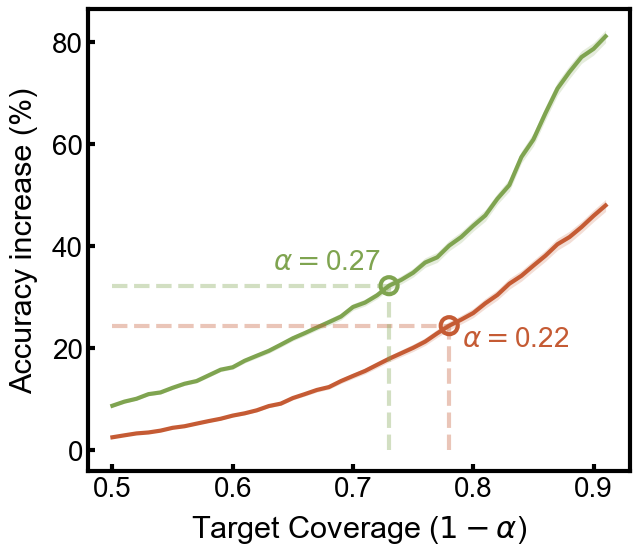

In [147]:
plt.rcParams['font.family'] = 'Arial'

all_alphas = np.arange(0.01, 0.99, 0.01)
plot_idx = np.logical_and(1-all_alphas <= 0.91, 1-all_alphas >= .5)
plot_alphas = all_alphas[plot_idx]
fig = plt.figure(figsize=(7, 6))

alpha_max = plot_alphas[alpha_max_idx]
alpha_max_same = plot_alphas[alpha_max_same_idx]

plt.plot(1-plot_alphas, acc_avg.flatten(), color=color_scheme[0], linewidth=3)
plt.fill_between(1-plot_alphas, acc_ci_lower.flatten(), acc_ci_upper.flatten(), color=color_scheme[0], alpha=.2, linewidth=0)

plt.plot(1-plot_alphas, acc_avg_same.flatten(), color=color_scheme[2], linewidth=3)
plt.fill_between(1-plot_alphas, acc_ci_lower_same.flatten(), acc_ci_upper_same.flatten(), color=color_scheme[2], alpha=.2, linewidth=0)

plt.plot([1-alpha_max, 1-alpha_max], [0., acc_avg_max], '--', linewidth=3, color=color_scheme[0], alpha=.35)
plt.plot([0.5, 1-alpha_max], [acc_avg_max, acc_avg_max], '--', linewidth=3, color=color_scheme[0], alpha=.35)
plt.text(1-alpha_max + 0.1, acc_avg_max - 0.1, rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', 
         horizontalalignment='right', fontsize=20, color=color_scheme[0])
plt.scatter(1-alpha_max, acc_avg_max, marker='o', s=150, color=color_scheme[0], linewidths=3, facecolors='none')

plt.plot([1-alpha_max_same, 1-alpha_max_same], [0., acc_avg_max_same], '--', linewidth=3, color=color_scheme[2], alpha=.35)
plt.plot([0.5, 1-alpha_max_same], [acc_avg_max_same, acc_avg_max_same], '--', linewidth=3, color=color_scheme[2], alpha=.35)
plt.text(1-alpha_max_same - 0.007, acc_avg_max_same + 7.2, rf'$\alpha=${alpha_max_same:.2f}', verticalalignment='top', 
         horizontalalignment='right', fontsize=20, color=color_scheme[2])
plt.scatter(1-alpha_max_same, acc_avg_max_same, marker='o', s=150, color=color_scheme[2], linewidths=3, facecolors='none')


plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 

plt.xticks(list(np.arange(0.5, 0.91, 0.1)), labels=['0.5', '0.6', '0.7', '0.8', '0.9'], fontsize=20) 
plt.locator_params(axis='y', nbins=6)
plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Accuracy increase (%)', fontsize=22, labelpad=10, fontdict=dict(fontstretch = 'condensed'))#, fontdict=dict(weight='bold'))
plt.show()

In [39]:
pr_avg_max_same

NameError: name 'pr_avg_max_same' is not defined

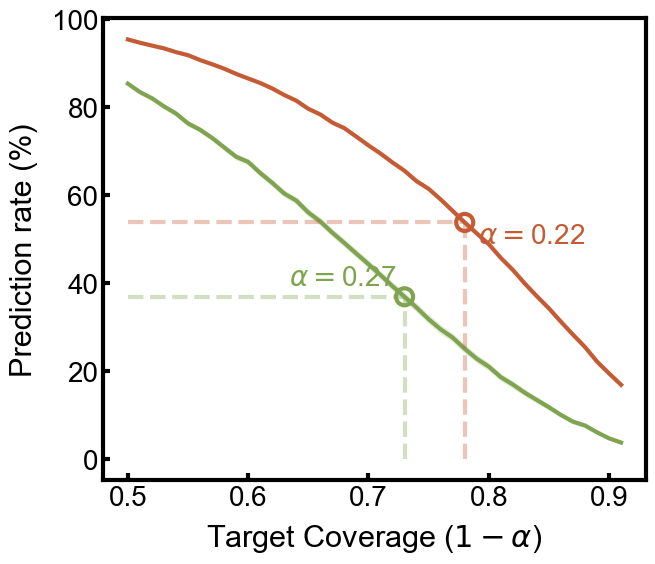

In [149]:
plt.rcParams['font.family'] = 'Arial'

all_alphas = np.arange(0.01, 0.99, 0.01)
plot_idx = np.logical_and(1-all_alphas <= 0.91, 1-all_alphas >= .5)
plot_alphas = all_alphas[plot_idx]
fig = plt.figure(figsize=(7, 6))

alpha_max = plot_alphas[alpha_max_idx]
alpha_max_same = plot_alphas[alpha_max_same_idx]

plt.plot(1-plot_alphas, pr_avg.flatten(), color=color_scheme[0], linewidth=3)
plt.fill_between(1-plot_alphas, pr_ci_lower.flatten(), pr_ci_upper.flatten(), color=color_scheme[0], alpha=.2, linewidth=0)

plt.plot(1-plot_alphas, pr_avg_same.flatten(), color=color_scheme[2], linewidth=3)
plt.fill_between(1-plot_alphas, pr_ci_lower_same.flatten(), pr_ci_upper_same.flatten(), color=color_scheme[2], alpha=.2, linewidth=0)

plt.plot([1-alpha_max, 1-alpha_max], [0., pr_avg_max], '--', linewidth=3, color=color_scheme[0], alpha=.35)
plt.plot([0.5, 1-alpha_max], [pr_avg_max, pr_avg_max], '--', linewidth=3, color=color_scheme[0], alpha=.35)
plt.text(1-alpha_max + 0.1, pr_avg_max - 0.1, rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', 
         horizontalalignment='right', fontsize=20, color=color_scheme[0])
plt.scatter(1-alpha_max, pr_avg_max, marker='o', s=150, color=color_scheme[0], linewidths=3, facecolors='none')

plt.plot([1-alpha_max_same, 1-alpha_max_same], [0., pr_avg_max_same], '--', linewidth=3, color=color_scheme[2], alpha=.35)
plt.plot([0.5, 1-alpha_max_same], [pr_avg_max_same, pr_avg_max_same], '--', linewidth=3, color=color_scheme[2], alpha=.35)
plt.text(1-alpha_max_same - 0.007, pr_avg_max_same + 7.2, rf'$\alpha=${alpha_max_same:.2f}', verticalalignment='top', 
         horizontalalignment='right', fontsize=20, color=color_scheme[2])
plt.scatter(1-alpha_max_same, pr_avg_max_same, marker='o', s=150, color=color_scheme[2], linewidths=3, facecolors='none')


plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 

plt.xticks(list(np.arange(0.5, 0.91, 0.1)), labels=['0.5', '0.6', '0.7', '0.8', '0.9'], fontsize=20) 
plt.locator_params(axis='y', nbins=6)
plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Prediction rate (%)', fontsize=22, labelpad=10, fontdict=dict(fontstretch = 'condensed'))#, fontdict=dict(weight='bold'))
plt.show()

## Safety analysis

In [166]:
# True labels are treated as when the classifier gives us correct labels VS incorrect labels. 
# I.e., the CP abstaining framework is treated like a binary classifier on when to abstain or not. 

np.random.seed(42)

all_alphas = list(np.arange(0.01, 1.00, 0.01))

n_iters = 100
true_positives = np.zeros((9, len(all_alphas), n_iters)); true_negatives = np.zeros((9, len(all_alphas), n_iters))
false_positives = np.zeros((9, len(all_alphas), n_iters)); false_negatives = np.zeros((9, len(all_alphas), n_iters))
baseline_accuracies = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    true_abstain = test_smx.argmax(1) != y_test.argmax(1); true_noabstain = ~true_abstain
    baseline_accuracies = np.mean(true_noabstain)
    for i_alpha, alpha in enumerate(all_alphas): 
        for j in range(n_iters): 
            ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
            pred_abstain = np.sum(ps, axis=1) > 1; pred_noabstain = np.sum(ps, axis=1) == 1
            tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
            fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
            assert tp + fp + fn + tn == X_test.shape[0]
                
            true_positives[subject_num, i_alpha, j] = tp
            true_negatives[subject_num, i_alpha, j] = tn
            false_positives[subject_num, i_alpha, j] = fp
            false_negatives[subject_num, i_alpha, j] = fn

np.save(f'{save_path}true_positives.npy', true_positives)
np.save(f'{save_path}true_negatives.npy', true_negatives)
np.save(f'{save_path}false_positives.npy', false_positives)
np.save(f'{save_path}false_negatives.npy', false_negatives)

  0%|          | 0/9 [00:00<?, ?it/s]

In [167]:
# True labels are treated as when the classifier gives us correct labels VS incorrect labels. 
# I.e., the CP abstaining framework is treated like a binary classifier on when to abstain or not. 

np.random.seed(42)

all_alphas = list(np.arange(0.01, 1.00, 0.01))

n_iters = 100
true_positives_same = np.zeros((9, len(all_alphas), n_iters)); true_negatives_same = np.zeros((9, len(all_alphas), n_iters))
false_positives_same = np.zeros((9, len(all_alphas), n_iters)); false_negatives_same = np.zeros((9, len(all_alphas), n_iters))
baseline_accuracies = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    
    X_val_test = all_X_test[subject_num]; y_val_test = all_y_test[subject_num]
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    true_abstain = test_smx.argmax(1) != y_test.argmax(1); true_noabstain = ~true_abstain
    baseline_accuracies = np.mean(true_noabstain)
    for i_alpha, alpha in enumerate(all_alphas): 
        for j in range(n_iters): 
            ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
            pred_abstain = np.sum(ps, axis=1) > 1; pred_noabstain = np.sum(ps, axis=1) == 1
            tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
            fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
            assert tp + fp + fn + tn == X_test.shape[0]
                
            true_positives_same[subject_num, i_alpha, j] = tp
            true_negatives_same[subject_num, i_alpha, j] = tn
            false_positives_same[subject_num, i_alpha, j] = fp
            false_negatives_same[subject_num, i_alpha, j] = fn

np.save(f'{save_path}true_positives_same.npy', true_positives_same)
np.save(f'{save_path}true_negatives_same.npy', true_negatives_same)
np.save(f'{save_path}false_positives_same.npy', false_positives_same)
np.save(f'{save_path}false_negatives_same.npy', false_negatives_same)

  0%|          | 0/9 [00:00<?, ?it/s]

In [168]:
tpr_diff, fpr_diff, precision_diff = compute_matrix_quantities(true_positives, true_negatives, false_positives, false_negatives)
tpr_same, fpr_same, precision_same = compute_matrix_quantities(true_positives_same, true_negatives_same, false_positives_same, false_negatives_same)

tpr = np.vstack((np.expand_dims(tpr_diff,0), np.expand_dims(tpr_same,0)))
fpr = np.vstack((np.expand_dims(fpr_diff,0), np.expand_dims(fpr_same,0)))
precision = np.vstack((np.expand_dims(precision_diff,0), np.expand_dims(precision_same,0)))

/Users/seonghyunyoon/Developer/conformal_prediction_bmi/plotting.py:679: RuntimeWarning: invalid value encountered in divide
  for subject_num in range(n1):


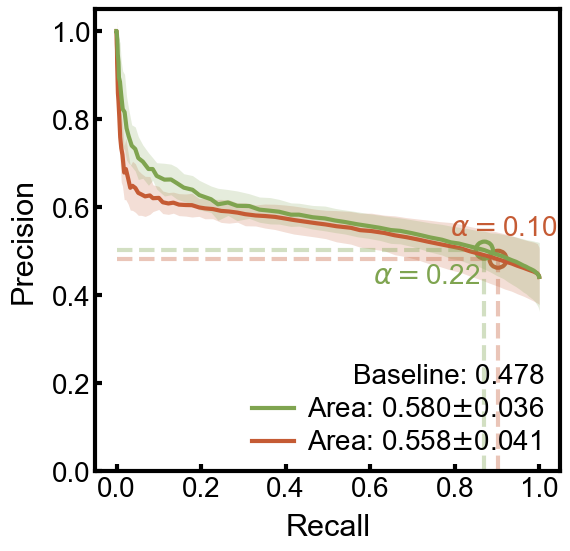

In [169]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
color_i = [0, 2]
x_adj = [.14, -.01]
y_adj = [0.1, -0.03]
y_area_adj = [0, 0.075]

naive_precision = np.mean(1-baseline_accuracies)

for i in range(2): 
    tpr_mean, ci_lower_tpr, ci_upper_tpr = compute_ci_mean(tpr[i])
    precision_mean, ci_lower_pre, ci_upper_pre = compute_ci_mean(precision[i])
    sort_index = np.argsort(tpr_mean)
    f1_scores = 2 * (precision_mean * tpr_mean) / (precision_mean + tpr_mean)
    # Find the threshold that maximizes the F1 score
    max_f1_index = np.argmax(f1_scores)
    alpha_max = (1 - np.arange(0.01, 1.00, 0.01))[sort_index][max_f1_index]
    precision_max = precision_mean[max_f1_index]
    tpr_max = tpr_mean[max_f1_index]
    
    tpr_sorted = tpr_mean[sort_index]
    ci_lower_tpr = ci_lower_tpr[sort_index]
    ci_upper_tpr = ci_upper_tpr[sort_index]
    precision_sorted = precision_mean[sort_index]
    ci_lower_pre = ci_lower_pre[sort_index]
    ci_upper_pre = ci_upper_pre[sort_index]
    area = np.trapz(precision_sorted, tpr_sorted)
    area_lower = np.trapz(ci_lower_pre, tpr_sorted)
    
    # Plot 1: Target Coverage (x) & Empirical Coverage
    plt.plot(tpr_sorted, precision_sorted, color=color_scheme[color_i[i]], linewidth=3)
    plt.fill_between(tpr_sorted, ci_lower_pre, ci_upper_pre, color=color_scheme[color_i[i]], alpha=.2, linewidth=0)
    plt.text(tpr_max+x_adj[i], precision_max+y_adj[i], rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', horizontalalignment='right', 
             fontsize=20, color=color_scheme[color_i[i]])
    plt.scatter(tpr_max, precision_max, marker='o', s=150, color=color_scheme[color_i[i]], linewidths=3, facecolors='none')
    
    plt.plot([tpr_max, tpr_max], [0, precision_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    plt.plot([np.min(tpr_sorted), tpr_max], [precision_max, precision_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)
    
    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here


    plt.text(0.45, 0.05+y_area_adj[i], rf'Area: {area:.3f}$\pm${(area-area_lower):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
    plt.plot([0.32, 0.42], [0.068+y_area_adj[i], 0.068+y_area_adj[i]], color=color_scheme[color_i[i]], linewidth=3)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(0, 1.05)
    plt.xlabel('Recall', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('Precision', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))
    
plt.text(0.56, 0.2, rf'Baseline: {naive_precision:.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.show()

Area under the curve: 0.6564748272672637 $\plusminus$ 0.04365284753958987
Area under the curve: 0.6508359480503261 $\plusminus$ 0.07679350318766764


<Figure size 600x600 with 0 Axes>

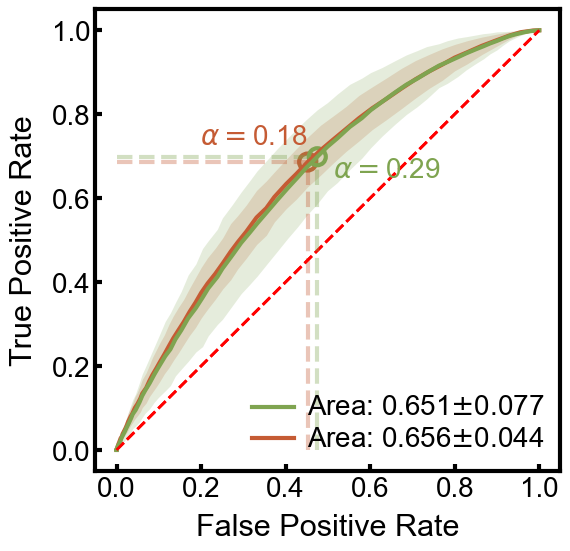

In [170]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
color_i = [0, 2]
x_adj = [0, .29]
y_adj = [0.09, 0]
y_area_adj = [0, 0.075]

naive_precision = np.mean(1-baseline_accuracies)
fig = plt.figure(figsize=(6, 6))

for i in range(2): 
    fpr_mean, ci_lower_fpr, ci_upper_fpr = compute_ci_mean(fpr[i])
    tpr_mean, ci_lower_tpr, ci_upper_tpr = compute_ci_mean(tpr[i])

    sort_index = np.argsort(fpr_mean)
    tpr_sorted = np.insert(np.append(tpr_mean[sort_index], 1), 0, 0)
    fpr_sorted = np.insert(np.append(fpr_mean[sort_index], 1), 0, 0)
    ci_lower_fpr = ci_lower_fpr[sort_index]
    ci_upper_fpr = ci_upper_fpr[sort_index]
    ci_lower_tpr = ci_lower_tpr[sort_index]
    ci_upper_tpr = ci_upper_tpr[sort_index]

    j_index = tpr_sorted - fpr_sorted  # Youden's J statistic
    max_j_index = np.argmax(j_index)
    alpha_max = (1 - np.arange(0.01, 1.00, 0.01))[sort_index][max_j_index]
    tpr_max = tpr_sorted[max_j_index]
    fpr_max = fpr_sorted[max_j_index]
    
    area = np.trapz(tpr_sorted[1:-1], fpr_sorted[1:-1])
    area_upper = np.trapz(ci_upper_tpr, fpr_sorted[1:-1])
    area_lower = np.trapz(ci_lower_tpr, fpr_sorted[1:-1])
    print(f"Area under the curve: {area} $\plusminus$ {area_upper-area}")


    plt.rcParams['font.family'] = 'Arial'
    plt.plot(fpr_sorted, tpr_sorted, color=color_scheme[color_i[i]], linewidth=3)
    plt.fill_between(fpr_sorted[1:-1], ci_lower_tpr, ci_upper_tpr, color=color_scheme[color_i[i]], alpha=.2, linewidth=0)

    plt.plot([0, 1], [0, 1], 'r--', label='y=x', linewidth=2)  # 'k--' is for black dotted line
    
    plt.text(fpr_max+x_adj[i], tpr_max+y_adj[i], rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', horizontalalignment='right', 
             fontsize=20, color=color_scheme[color_i[i]], zorder=2)
    plt.scatter(fpr_max, tpr_max, marker='o', s=150, color=color_scheme[color_i[i]], linewidths=3, facecolors='none')
    
    plt.plot([fpr_max, fpr_max], [0, tpr_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    plt.plot([0, fpr_max], [tpr_max, tpr_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.plot([0.32, 0.42], [0.028+y_area_adj[i], 0.028+y_area_adj[i]], color=color_scheme[color_i[i]], linewidth=3)
    
    plt.xlabel('False Positive Rate', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('True Positive Rate', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))
    plt.text(0.45, 0.01+y_area_adj[i], rf'Area: {area:.3f}$\pm${(area-area_lower):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))

plt.show()

## Pvalues

In [4]:
from scipy.stats import kstest

n_iters = 100

np.random.seed(42) 

pvalues = np.zeros((9, 100, n_iters))
sample_percentages = list(np.arange(0.01, 1.01, 0.01)) 

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    n_test = X_test.shape[0]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for percentage_idx, test_percentage in enumerate(sample_percentages):
        curr_n_test = int(np.ceil(n_test * test_percentage))  # Ceil to avoid empty set 
        for i in range(n_iters): 
            random_indices = np.random.choice(n_test, size=curr_n_test, replace=False)
            val_score, test_score = get_conformity_scores(val_smx, y_val, test_smx[random_indices], y_test[random_indices])
            pvalues[subject_num, percentage_idx, i] = kstest(val_score, test_score)[1]


  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
np.save(f'{save_path}/pvalues.npy', pvalues)

In [37]:
all_X_train = []; all_y_train = []; all_X_val = []; all_y_val = []; all_X_test = []; all_y_test = []

model_path = f'/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 1 (ideal)//saved_models/'
all_models = [] 

for subject_num in tqdm(range(1, 10)): 
    # Load data 
    X_train, y_train = get_data(subject_num, training=True, path=data_path)
    X_val_test, y_val_test = get_data(subject_num, training=False, path=data_path)
    X_train, y_train = prepare_features(X_train, y_train)
    X_val_test, y_val_test = prepare_features(X_val_test, y_val_test)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=.65, random_state=42)
    
    # Scale the data
    for j in range(n_channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
    # Append to total data 
    all_X_train.append(X_train); all_y_train.append(y_train)
    all_X_val.append(X_val); all_y_val.append(y_val)
    all_X_test.append(X_test); all_y_test.append(y_test)
    
    # Prepare model
    curr_model_path = f'{model_path}/model_{subject_num}.h5'
    _, _, n_channels, n_time = X_train.shape
    n_classes = y_train.shape[1]
    model = EEGTCNet(nb_classes = n_classes, Chans=n_channels, Samples=n_time, layers=L, kernel_s=KT, filt=FT, dropout=pt, activation='elu', 
                     F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    model.load_weights(curr_model_path)
    all_models.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

In [249]:
save_path = '/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 2 (loso)/'

In [250]:
n_iters = 100
pvalues_indl = np.zeros((72, 100, n_iters))
sample_percentages = list(np.arange(0.01, 1.01, 0.01)) 

np.random.seed(42) 
save_idx = 0 
for i in tqdm(range(9), total=9): 
    for j in range(9): 
        if i != j: 
            model = all_models[i]
            X_val = all_X_val[i]; y_val = all_y_val[i]; X_test = all_X_test[j]; y_test = all_y_test[j]
            n_val = X_val.shape[0]
            val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
            for percentage_idx, val_percentage in enumerate(sample_percentages):
                curr_n_val = int(np.ceil(n_val * val_percentage))  # Ceil to avoid empty set 
                for n_iter in range(n_iters): 
                    random_indices = np.random.choice(n_val, size=curr_n_val, replace=False)
                    val_score, test_score = get_conformity_scores(val_smx[random_indices], y_val[random_indices], test_smx, y_test)
                    pvalues_indl[save_idx, percentage_idx, n_iter] = kstest(val_score, test_score)[1]
            save_idx += 1

np.save(f'{save_path}/pvalues_indl.npy', pvalues_indl)

  0%|          | 0/9 [00:00<?, ?it/s]

In [38]:
0.07 * np.sum([all_X_test[i].shape[0] for i in range(9)]) / 9 

6.478888888888889

In [19]:
pvalues = np.load(f'{save_path}/pvalues.npy')
pvalues = pvalues.transpose(0, 2, 1).reshape(100 * 9, len(sample_percentages))

ValueError: axes don't match array

In [22]:
pvalues_indl.shape

(72, 100, 100)

In [24]:
pvalues_indl = np.load(f'{save_path}/pvalues_indl.npy')
pvalues_indl = pvalues_indl.transpose(0, 2, 1).reshape(100 * 72, 100)

In [7]:
pvalues = pvalues.transpose(0, 2, 1).reshape(100 * 9, len(sample_percentages))

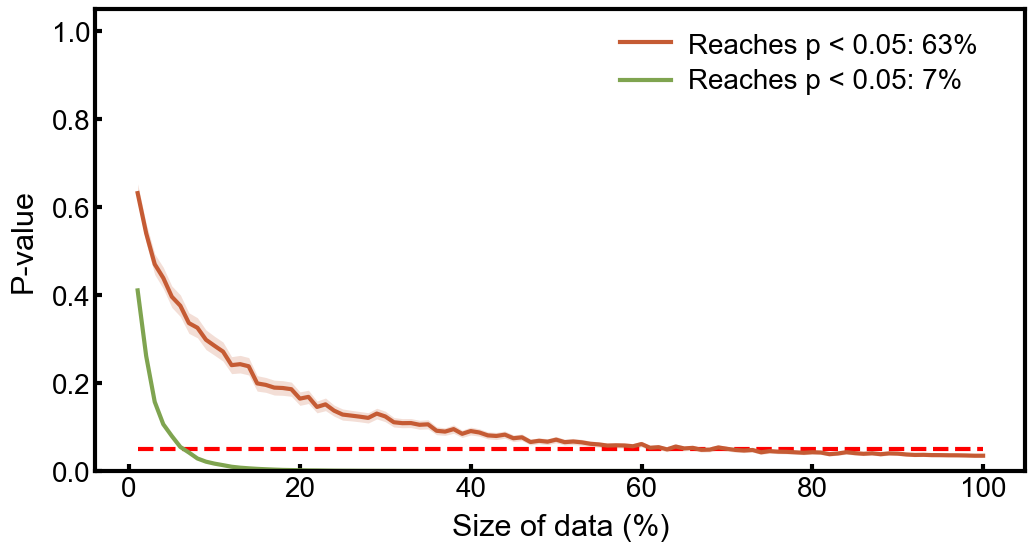

In [26]:
x = np.arange(0.01, 1.01, 0.01)
fig = plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Arial'

avg, ci_lower, ci_upper = compute_ci_mean(pvalues)
avg_same, ci_lower_same, ci_upper_same = compute_ci_mean(pvalues_indl)

plt.plot(100 * x, [0.05] * len(x), 'r--', linewidth=3)
plt.plot(100 * x, avg, color=color_scheme[0], linewidth=3)
plt.fill_between(100 * x, ci_lower, ci_upper, color=color_scheme[0], alpha=.2, linewidth=0)
plt.plot(100 * x, avg_same, color=color_scheme[2], linewidth=3)
plt.fill_between(100 * x, ci_lower_same, ci_upper_same, color=color_scheme[2], alpha=.2, linewidth=0)
plt.grid(False)

plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 

first_percentage = x[np.argmax(avg <= 0.051)] * 100
first_percentage_same = x[np.argmax(avg_same <= 0.051)] * 100

y_area_adj = [0.91,0.9]
#plt.xticks(x, labels=['0', '20', '40', '60', '80', '100'], fontsize=20) 
plt.text(65.5, 0.95, rf'Reaches p < 0.05: {first_percentage:.0f}%', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.plot([57.5, 63.5], [0.975, 0.975], color=color_scheme[0], linewidth=3)

plt.text(65.5, 0.87, rf'Reaches p < 0.05: {first_percentage_same:.0f}%', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.plot([57.5, 63.5], [0.888, 0.888], color=color_scheme[2], linewidth=3)

plt.xlabel('Size of data (%)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('P-value', fontsize=22, labelpad=10, fontdict=dict(fontstretch = 'condensed'))#, fontdict=dict(weight='bold'))
plt.ylim(0, 1.05)
plt.show()

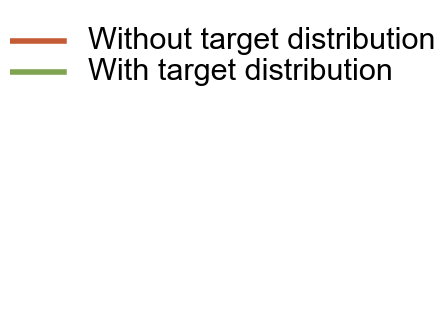

In [35]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(2, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.07] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['Without target distribution', 'With target distribution']
color_scheme_idx = [0, 2]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([0, length], [pos, pos], color=color_scheme[color], lw=4)
    # Add corresponding label
    ax.text(length + 0.03, pos, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()

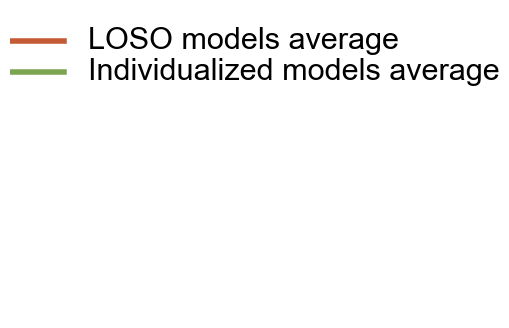

In [36]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(2, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.07] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['LOSO models average', 'Individualized models average']
color_scheme_idx = [0, 2]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([0, length], [pos, pos], color=color_scheme[color], lw=4)
    # Add corresponding label
    ax.text(length + 0.03, pos, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()